In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import gpytorch


from utils import SineTask, CosineTask, TaskDistribution

print('torch version : ', torch.__version__)
print('gpytorch version : ', gpytorch.__version__)

torch version :  1.10.1+cu102
gpytorch version :  1.6.0


## Build the deep kernel model

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        #self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        #out = self.layer3(out)
        return out

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
#         x_normalized = x - x.min(0)[0]
#         x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 
        #x = (x+5)/10
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Parameters of the experiment

In [39]:
n_shot_train_range = 15
n_shot_test = 5
sample_size = 200
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
criterion = nn.MSELoss()

num_iterations = 30000

# instantiate the distribution from which the tasks are sampled
tasks = TaskDistribution(amplitude_min=0.1, amplitude_max=5.0, 
                          phase_min=0.0, phase_max=np.pi, 
                          x_min=train_range[0], x_max=train_range[1], 
                          family="sine")

test_tasks = TaskDistribution(amplitude_min=0.1, amplitude_max=5.0, 
                               phase_min=0.0, phase_max=np.pi, 
                               x_min=test_range[0], x_max=test_range[1], 
                               family="sine")
# define model 
net = FeatureExtractor()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
dummy_inputs = torch.zeros([n_shot_train,40])
dummy_labels = torch.zeros([n_shot_train])

gp = ExactGPModel(dummy_inputs, dummy_labels, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([
    {'params': gp.parameters(), 'lr': 1e-3},
    {'params': net.parameters(), 'lr': 1e-3}
])

In [40]:
# training loop
likelihood.train()
gp.train()
net.train()

FeatureExtractor(
  (layer1): Linear(in_features=1, out_features=40, bias=True)
  (layer2): Linear(in_features=40, out_features=40, bias=True)
)

In [41]:
losses = []
criteria = []

for iter_ in range(num_iterations):

    optimizer.zero_grad()
    features, targets = tasks.sample_task().sample_data(n_shot_train, noise=0.1)
    
    z = net(features)
    gp.set_train_data(inputs=z, targets=targets)
    
    predictions = gp(z)
    
    loss = -mll(predictions, gp.train_targets)
    loss.backward()
    optimizer.step()
    
    mse = criterion(predictions.mean, targets)
    
    # record loss
    if iter_ % 100 == 0:
        losses.append(loss)
        criteria.append(mse)
    
    # print log
    if iter_ % 1000 == 0:
        # print information about the training
        print(f'EPOCH {iter_} : Loss: {loss.item():.3f} MSE: {mse.item():.3f} lengthscale : 0.0 noise : {gp.likelihood.noise.item():.3f}')
        
        
        

EPOCH 0 : Loss: 1.643 MSE: 3.022 lengthscale : 0.0 noise : 0.693
EPOCH 1000 : Loss: 1.366 MSE: 2.126 lengthscale : 0.0 noise : 0.528
EPOCH 2000 : Loss: 0.867 MSE: 0.485 lengthscale : 0.0 noise : 0.271
EPOCH 3000 : Loss: 0.929 MSE: 1.634 lengthscale : 0.0 noise : 0.111
EPOCH 4000 : Loss: 1.625 MSE: 6.529 lengthscale : 0.0 noise : 0.045
EPOCH 5000 : Loss: 1.443 MSE: 12.334 lengthscale : 0.0 noise : 0.021
EPOCH 6000 : Loss: 1.827 MSE: 10.040 lengthscale : 0.0 noise : 0.012
EPOCH 7000 : Loss: 1.096 MSE: 4.425 lengthscale : 0.0 noise : 0.009
EPOCH 8000 : Loss: 0.336 MSE: 0.235 lengthscale : 0.0 noise : 0.008
EPOCH 9000 : Loss: 0.367 MSE: 1.329 lengthscale : 0.0 noise : 0.008
EPOCH 10000 : Loss: 0.463 MSE: 0.240 lengthscale : 0.0 noise : 0.008
EPOCH 11000 : Loss: 0.910 MSE: 9.148 lengthscale : 0.0 noise : 0.008
EPOCH 12000 : Loss: 0.812 MSE: 4.278 lengthscale : 0.0 noise : 0.008
EPOCH 13000 : Loss: 0.487 MSE: 0.482 lengthscale : 0.0 noise : 0.008
EPOCH 14000 : Loss: 0.459 MSE: 0.134 lengthsc

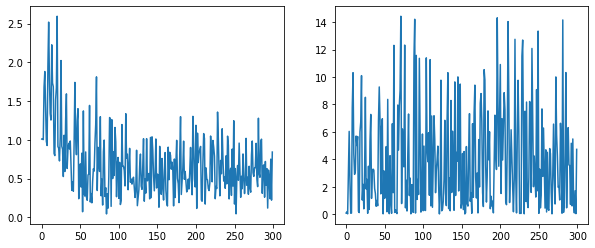

In [8]:
# plot the losses
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(losses)
axes[1].plot(criteria)

In [33]:
# testing 
likelihood.eval()
net.eval()

sample_task = test_tasks.sample_task()
sample_size = 200
x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
indices = np.arange(sample_size)
np.random.shuffle(indices)
support_indices = np.sort(indices[0:n_shot_test])

query_indices = np.sort(indices[n_shot_test:])
x_support = x_all[support_indices]
y_support = y_all[support_indices]
x_query = x_all[query_indices]
y_query = y_all[query_indices]

z_support = net(x_support).detach()
gp.train()
gp.set_train_data(inputs=z_support, targets=y_support, strict=False)  
gp.eval()

#Evaluation on all data
z_all = net(x_all).detach()
mean = likelihood(gp(z_all)).mean
lower, upper = likelihood(gp(z_all)).confidence_region() #2 standard deviations above and below the mean

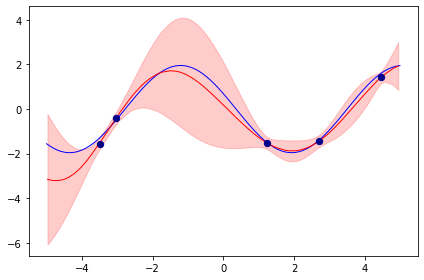

In [34]:
fig, ax = plt.subplots()

true_x = np.linspace(train_range[0], train_range[1], 200)
true_y = [sample_task.true_function(x) for x in true_x]

ax.plot(true_x, true_y, color='b', lw=1)

ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='r', lw=1)
ax.fill_between(
        np.squeeze(x_all),
        lower.detach().numpy(),
        upper.detach().numpy(),
        alpha=.2, 
        color='red',
    )

# support points
ax.scatter(x_support, y_support, color='darkblue', marker='o', s=40, zorder=10)
plt.tight_layout()